<a href="https://colab.research.google.com/github/nicoelbert/vehicleroutingproblem/blob/main/vehicle_routing_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Routing Problem
vehicle routing problem on complete information using simmulated annealing

#Preparation

In [17]:
#inital run
if False:
  !pip install pulp
  !git clone 'https://github.com/nicoelbert/vehicleroutingproblem'
  %cd vehicleroutingproblem

In [18]:
#import packages
import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime

#custom calsses
!git pull
from classes import classes as cl
from functions import functions as fc
from functions import routing as rt


Already up to date.


In [19]:
!git pull
!ls

Already up to date.
classes  functions  original_data  README.md  vehicle_routing_solver.ipynb


##Data Import

In [20]:
def get_proxdepot(site,plant):
  
  distance_min = 10000000000000
  depot_min = ''
  for d in list_depots:
    distance_ges = rt.get_distance(d,site) + rt.get_distance(d,plant)
    if distance_ges < distance_min:
      distance_min = distance_ges
      depot_min = d
  return depot_min


In [24]:
#depot masterdata
print("Starting with Data Import at {}".format(fc.get_time()))



#load Masterdata from csv
url = 'https://raw.githubusercontent.com/nicoelbert/vehicleroutingproblem/main/original_data/Depots.csv'
df_depots = pd.read_csv(url)


#load basetable
url = 'https://raw.githubusercontent.com/nicoelbert/vehicleroutingproblem/main/original_data/preparedJobs.csv'
df_jobs_org = pd.read_csv(url)

#create and fill dict_depots

dict_depots = {}
list_depots = []

for index, row in df_depots.iterrows():
  depot = cl.Depot(row['Werk'],row['Werk_lon'],row['Werk_lat'])
  dict_depots[row['Werk']] = depot
  list_depots.append(depot)

print("{} depots created".format(len(dict_depots)))


#create and fill plants from df_jobs_org
dict_plants = {}
list_plants = []

list_plant_names = df_jobs_org['Werk'].unique() 

for pn in list_plant_names:
  row = df_jobs_org[df_jobs_org['Werk'] == pn].iloc[0]
  plant = cl.Plant(row.Werk,row.Werk_lon,row.Werk_lat)
  dict_plants[plant.name] = plant
  list_plants.append(plant)

print("{} plants created".format(len(dict_plants)))


#create and fill sites from df_jobs_org

dict_sites = {}
list_sites = []

df_sites = df_jobs_org[['plz','lon','lat']].copy()
df_sites.drop_duplicates(inplace=True)


for index, row in df_sites.iterrows():
  site = cl.Site(row.plz,row.lon,row.lat)
  dict_sites[site.name] = site
  list_sites.append(site)


print("{} sites created".format(len(dict_sites)))


#create and fill jobs from df_jobs_org


dict_jobs = {}
list_jobs = []
list_emsen_jobs = []

for index, row in df_jobs_org.iterrows():
  plant = dict_plants[row.Werk]
  site_name = str(row.plz) + '/' +str(row.lon) + '/' + str(row.lat)
  site = dict_sites[site_name]
  prox_depot = get_proxdepot(site,plant)
  job = cl.Job(row.id, row.key, plant,row.Maschinentechnik,row.Material,row.Start_clean,(row.Start_clean + row.Werktage), row.Werktage, site, prox_depot )
  dict_jobs[job.id] = job
  list_jobs.append(job)



print("{} jobs created".format(len(dict_jobs)))


#create list of days
# since the timespan is 1208 days and there are only 895 relevant days lets work with these first

list_days = []


for j in list_jobs: 
  if j.start not in list_days:
    list_days.append(j.start)
  if j.end not in list_days:
    list_days.append(j.end)

list_days.sort()
print("Working with {} relevant days".format(len(list_days)))


#create one tour for each day and depot

dict_tours = {}
total = 0

for depot in dict_depots:
  dict_tours[depot] = {}

for depot in list_depots:
  for day in list_days:
    dict_tours[depot.name][day] = cl.Tour(depot,day)
  total = total + len(dict_tours[depot.name])

print("{} tours created".format(total))


print("Done with Data Import at {}".format(fc.get_time()))

Starting with Data Import at 03:12:44
15 depots created
8 plants created
6166 sites created
53178 jobs created
Working with 895 relevant days
13425 tours created
Done with Data Import at 03:12:57


Visualize Data


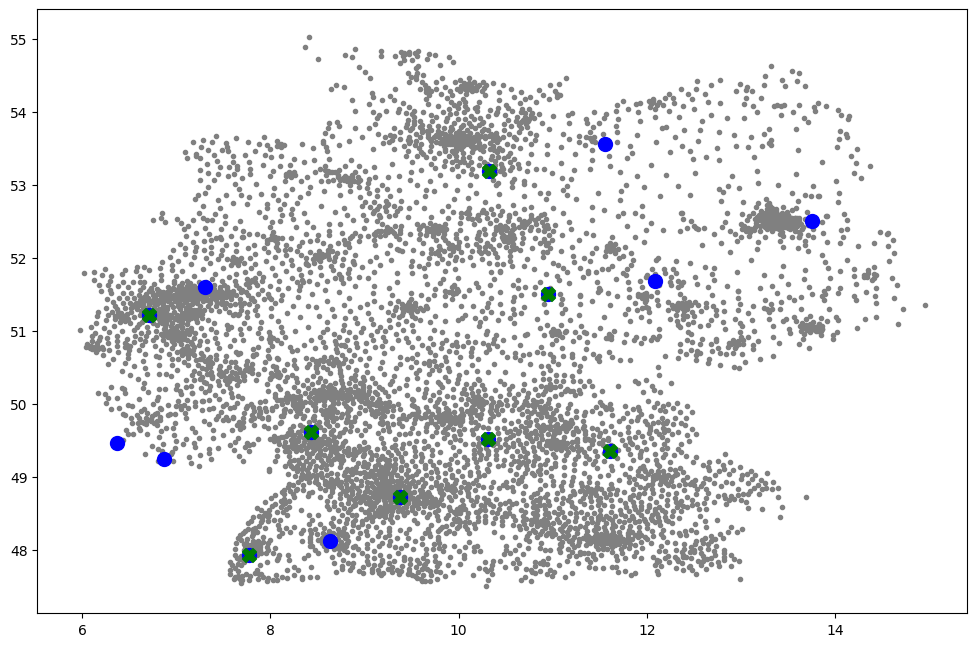

In [25]:
fc.get_map(list_depots,list_plants,list_sites)

Inital Solution

In [26]:
#create inital solution
""" every silo is delivered on the day it is needed and picked up the day it is not needed anymore, the tour swichtes between plant and sites - starting and ending at the depot"""

print("Starting with inital solution at {}".format(fc.get_time()))

for j in list_jobs: 
  j.dropoff_day = j.start
  j.pickup_day = j.end
  j.dropoff_depot = j.prox_depot
  j.pickup_depot = j.prox_depot
  j.dropoff_tour = dict_tours[j.dropoff_depot.name][j.dropoff_day]
  j.pickup_tour = dict_tours[j.pickup_depot.name][j.pickup_day]
  if j not in j.dropoff_tour.list_dropoffs:
    j.dropoff_tour.list_dropoffs.append(j)
  if j not in j.pickup_tour.list_pickups:
    j.pickup_tour.list_pickups.append(j)
  if j.plant not in j.pickup_tour.list_plants:
    j.pickup_tour.list_plants.append(j.plant)

i_pickups = 0
i_dropoffs = 0
i_multiple_plants = 0

for depot in dict_depots:
  for day in list_days:
   i_pickups = i_pickups + len(dict_tours[depot][day].list_pickups)
   i_dropoffs = i_dropoffs + len(dict_tours[depot][day].list_dropoffs)
   if len(dict_tours[depot][day].list_plants) > 1:
     i_multiple_plants = i_multiple_plants + 1
     print("Warning at Tour from {} and day {} - {} plants listed".format(depot,day,len(dict_tours[depot][day].list_plants)))
     p_names = []
     for p in dict_tours[depot][day].list_plants:
       p_names.append(p.name)
     print(p_names)


print(i_multiple_plants)
print("There are {} dropoffs and {} pickups listet which creates a difference of {}".format(i_dropoffs,i_pickups,i_dropoffs-i_pickups))

print("Done with inital solution at {}".format(fc.get_time())) 

Starting with inital solution at 03:13:13
Warning at Tour from Neuherberg and day 16900 - 2 plants listed
['Lauterhofen', 'Neuherberg']
Warning at Tour from Embsen and day 17042 - 2 plants listed
['Rottleberode', 'Embsen']
2
There are 53178 dropoffs and 53178 pickups listet which creates a difference of 0
Done with inital solution at 03:13:13


In [54]:
#!pip install pulp
from pulp import *

def routing(tour: cl.Tour):
    #double plants need to be handled
    #sites with doublefunction need to be handled (so input,output)

    depot_node = tour.depot
    plant_node = tour.list_plants[0] #only first plant is selected

    #format jobs to sites
    dropoff_nodes = []
    pickup_nodes = []
    
    for j in tour.list_dropoffs:
      dropoff_nodes.append(j.site)
    for j in tour.list_pickups:
      pickup_nodes.append(j.site)

    #combined lists
    site_nodes = dropoff_nodes + pickup_nodes
    vis_nodes = site_nodes
    vis_nodes.append(plant_node)
    all_nodes = vis_nodes
    all_nodes.append(depot_node)

    for n in pickup_nodes:
      if n in dropoff_nodes:
        print("error with %s" % n)

    #create enough timeslots at least one plantslot after each site
    i_timeslots = len(site_nodes) * 2
    timeslots = []

    for i in range(i_timeslots):
        timeslots.append(i)

    #create distance dict
    distances = {}
    for n in all_nodes:
      distances[n] = {}

    
    for i in all_nodes:
      for j in all_nodes:
        distances[i][j] = rt.get_distance(i,j)
    
    #create model
    m = LpProblem("Routing", LpMinimize)

    # create Variables
    x = LpVariable.dicts('edge', (all_nodes, all_nodes, timeslots), cat='Binary')
    y = LpVariable.dicts('load_truck', (timeslots), cat='Binary')
    z = LpVariable.dicts('load_silo', (timeslots), cat='Binary')

    #define constraints
    
    #a node cannot have an edge with itself
    iteration = 0
    for i in vis_nodes:
      m += LpAffineExpression([(x[i][i][t], 1) for t in timeslots]) == 0, 'no_selfvisit_i{}_{}'.format(iteration,i.name) #name adjusted bc of double functions of nodes
      iteration += 1

    #flow in and out constraints node
    for j in site_nodes:
       m += LpAffineExpression([(x[i][i][t], 1) for t in timeslots for i in site_nodes if i!=j]) <= 1, 'flow_in_%s' % i



    # Objective
    m += LpAffineExpression([(x[i][j][t], distances[i][j]) for i in all_nodes for j in all_nodes for t in timeslots])



    m.solve()
    print(m.status)




routing(dict_tours['Embsen'][17042])

error with <classes.classes.Site object at 0x7f0423f1c588>


PulpError: ignored

In [38]:

        # Constraints
    for i in range(nb_actions):
        m += x[i][i+nb_actions] == 1, 'fixed_edge_%s' % i

    for i in nodes:
        m += LpAffineExpression([(x[i][j], 1) for j in nodes if i!=j]) == 1 , 'flow_in_%s' % i
        m += LpAffineExpression([(x[j][i], 1) for j in nodes if i!=j]) == 1 , 'flow_out_%s' % i

        for j in nodes:
            if j not in (0, i):
                m += q[i] - q[j] + (nb_nodes - 1) * x[i][j] <= nb_nodes - 2

/usr/local/lib/python3.6/dist-packages/pulp/pulp.py:1537: UserWarning: Overwriting previously set objective.
  warnings.warn("Overwriting previously set objective.")


NameError: ignored

##Backup

In [ ]:
#notes
"""tour contains list of pickup and dropoff node,

"inital solution transport every silo back and forth on a tour prior to the"
"create a tour with list of pickups and list of deliveries - also need to include silo types?"""

In [ ]:
#question
""""really repos or whole problem?"



"how many silos"
"max_km"
"how early"""

In [ ]:
#assumption
"""
max_km? 
max_tour/depot = 1

In [ ]:
#backup

#distance depot,plants
"""
for d in list_depots:
  for p in list_plants:
    print('{} nach {} sind {}'.format(d.name,p.name,fc.get_distance(d,p)))
"""

"""
"eval of sites"
print(len(df_jobs['plz'].unique()))
print(len(df_jobs['lon'].unique()))
print(len(df_jobs['lat'].unique()))
#print(len(df_jobs[['lon','lat']]()))

df_sites = df_jobs[['lon','lat']].copy()

print(df_sites.shape)

df_sites.drop_duplicates(inplace=True)


print(df_sites.shape)
k.key
"""
